In [13]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [14]:
train_dir = 'data/Training'
test_dir = 'data/Testing'
classes = os.listdir(train_dir)

In [15]:
resize_size = 256
crop_size = 224

def preprocess_image(image):
    image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR) #크기 조절
    image = tf.image.central_crop(image, central_fraction=crop_size / resize_size) #중앙 224x224
    image = tf.math.divide(image, 255.0) #normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std #다 normalize

    return image

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rotation_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

In [17]:
from sklearn.preprocessing import LabelEncoder

X = [] #Image
y = [] #class
for i in classes:
    for data_dir in [train_dir, test_dir]:
        folderPath = os.path.join(data_dir,i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j)) 
            img = preprocess_image(img)
            X.append(img)
            y.append(i)
X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical([classes.index(label) for label in y])

100%|████████████████████████████████████████████| 74/74 [00:00<00:00, 160.04it/s]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42) #training 분할 (train,val)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42) #training 분할 (train,val)

In [19]:
train_data = data_gen.flow(x=X_train, y=y_train)


In [20]:
#그래프 그려주는 거 (성능 그래프)
def plot_acc_model(acc, val_acc, epochs):
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

def plot_loss_model(loss, val_loss, epochs):
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, EfficientNetV2L, ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import os
from vit_keras import vit, utils

epochs=100

def create_and_compile_model(base_model, output_size, model_name):
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    output = Dense(output_size, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model_dir = f"aug01_model/{model_name}/"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
    best_model_checkpoint = ModelCheckpoint(f"{model_dir}best_model.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    csv_logger = CSVLogger(f'aug01_model/training_log_{model_name}.csv', separator=',', append=False)
    return model, [early_stopping, best_model_checkpoint,csv_logger]


#base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#model_vgg, callbacks_vgg = create_and_compile_model(base_model_vgg, output_size=4, model_name='vgg')
#base_model_efficientnet = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#model_efficientnet, callbacks_efficientnet = create_and_compile_model(base_model_efficientnet, output_size=4, model_name='eff')
#base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet, callbacks_resnet = create_and_compile_model(base_model_resnet, output_size=4, model_name='resnet')
#base_model_vit = vit.vit_b16(image_size=224, activation='sigmoid', pretrained=True)
#model_vit, callbacks_vit = create_and_compile_model(base_model_vit, output_size=4, model_name='vit')


'''
history_vit = model_vit.fit(train_data,
                                  epochs=epochs,
                                  validation_data=(X_val, y_val),
                                  verbose=1,
                                  callbacks=callbacks_vit)

history_vgg = model_vgg.fit(train_data,
                            epochs=epochs,
                            validation_data=(X_val, y_val),
                            verbose=1,
                            callbacks=callbacks_vgg)

history_efficientnet = model_efficientnet.fit(train_data,
                                              epochs=epochs,
                                              validation_data=(X_val, y_val),
                                              verbose=1,
                                              callbacks=callbacks_efficientnet)

'''
history_resnet = model_resnet.fit(train_data,
                                  epochs=epochs,
                                  validation_data=(X_val, y_val),
                                  verbose=1,
                                  callbacks=callbacks_resnet)

Epoch 1/100
83/83 [==============================] - ETA: 0s - loss: 9.3765 - accuracy: 0.4071
Epoch 1: val_loss improved from inf to 4.77750, saving model to aug01_model/resnet/best_model.h5
83/83 [==============================] - 54s 506ms/step - loss: 9.3765 - accuracy: 0.4071 - val_loss: 4.7775 - val_accuracy: 0.5238
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 5.7093 - accuracy: 0.5112
Epoch 2: val_loss improved from 4.77750 to 2.49530, saving model to aug01_model/resnet/best_model.h5
83/83 [==============================] - 28s 336ms/step - loss: 5.7093 - accuracy: 0.5112 - val_loss: 2.4953 - val_accuracy: 0.6156
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 4.6076 - accuracy: 0.5547
Epoch 3: val_loss did not improve from 2.49530
83/83 [==============================] - 18s 211ms/step - loss: 4.6076 - accuracy: 0.5547 - val_loss: 13.6138 - val_accuracy: 0.4422
Epoch 4/100
83/83 [==============================] - ETA: 0s - loss: 4.47

Epoch 29/100
83/83 [==============================] - ETA: 0s - loss: 1.3096 - accuracy: 0.8078
Epoch 29: val_loss did not improve from 0.72161
83/83 [==============================] - 28s 330ms/step - loss: 1.3096 - accuracy: 0.8078 - val_loss: 0.8046 - val_accuracy: 0.8571
Epoch 30/100
83/83 [==============================] - ETA: 0s - loss: 0.9927 - accuracy: 0.8358
Epoch 30: val_loss did not improve from 0.72161
83/83 [==============================] - 30s 359ms/step - loss: 0.9927 - accuracy: 0.8358 - val_loss: 1.3019 - val_accuracy: 0.8299
Epoch 31/100
83/83 [==============================] - ETA: 0s - loss: 1.4927 - accuracy: 0.8010
Epoch 31: val_loss did not improve from 0.72161
83/83 [==============================] - 28s 341ms/step - loss: 1.4927 - accuracy: 0.8010 - val_loss: 3.2659 - val_accuracy: 0.7143
Epoch 32/100
83/83 [==============================] - ETA: 0s - loss: 1.3147 - accuracy: 0.7987
Epoch 32: val_loss did not improve from 0.72161
83/83 [=====================

Epoch 58/100
83/83 [==============================] - ETA: 0s - loss: 0.5461 - accuracy: 0.8929
Epoch 58: val_loss did not improve from 0.60955
83/83 [==============================] - 28s 332ms/step - loss: 0.5461 - accuracy: 0.8929 - val_loss: 0.6110 - val_accuracy: 0.8844
Epoch 59/100
83/83 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.9081
Epoch 59: val_loss improved from 0.60955 to 0.58039, saving model to aug01_model/resnet/best_model.h5
83/83 [==============================] - 28s 340ms/step - loss: 0.4077 - accuracy: 0.9081 - val_loss: 0.5804 - val_accuracy: 0.9014
Epoch 60/100
83/83 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.9047
Epoch 60: val_loss did not improve from 0.58039
83/83 [==============================] - 30s 361ms/step - loss: 0.4259 - accuracy: 0.9047 - val_loss: 0.8642 - val_accuracy: 0.8537
Epoch 61/100
83/83 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.8831
Epoch 61: val_loss did

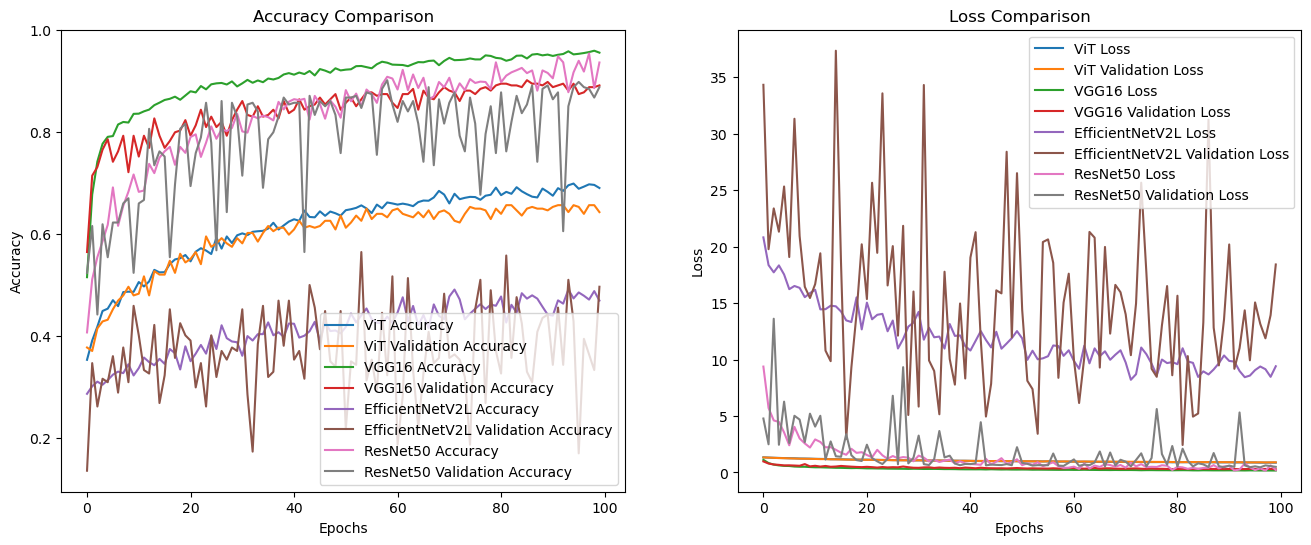

In [26]:
import matplotlib.pyplot as plt

# Function to plot metrics for each model
def plot_metrics(ax, histories, model_names, metric_name):
    for history, model_name in zip(histories, model_names):
        ax.plot(history.history[metric_name], label=f'{model_name} {metric_name.capitalize()}')
        ax.plot(history.history[f'val_{metric_name}'], label=f'{model_name} Validation {metric_name.capitalize()}')

    ax.set_title(f'{metric_name.capitalize()} Comparison')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name.capitalize())
    ax.legend()

# Create a list of model histories and names
model_histories = [history_vit, history_vgg, history_efficientnet, history_resnet]
model_names = ['ViT', 'VGG16', 'EfficientNetV2L', 'ResNet50']

# Create subplots for accuracy
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting training and validation accuracy for each model
plot_metrics(axs[0], model_histories, model_names, 'accuracy')

# Plotting training and validation loss for each model
plot_metrics(axs[1], model_histories, model_names, 'loss')

plt.show()

In [27]:
from sklearn.metrics import classification_report,accuracy_score


for model_name in ["eff", "resnet", "vgg", "vit"]:
    best_model = keras.models.load_model("aug01_model/"+model_name+"/best_model.h5")
    y_pred = best_model.predict(X_test)
    y_pred_single_label = np.argmax(y_pred, axis=1)
    y_test_single_label = np.argmax(y_test, axis=1)
    from sklearn.metrics import classification_report,accuracy_score
    class_report = classification_report(y_test_single_label, y_pred_single_label, zero_division=1)
    print(str(model_name))
    print(class_report)

11/11 [==============================] - 67s 4s/step
eff
              precision    recall  f1-score   support

           0       0.90      0.49      0.64        75
           1       0.39      0.49      0.43        80
           2       0.40      0.65      0.50        85
           3       0.78      0.44      0.56        87

    accuracy                           0.52       327
   macro avg       0.62      0.52      0.53       327
weighted avg       0.61      0.52      0.53       327

11/11 [==============================] - 12s 639ms/step
resnet
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        75
           1       0.86      0.84      0.85        80
           2       0.90      0.88      0.89        85
           3       0.91      0.99      0.95        87

    accuracy                           0.91       327
   macro avg       0.91      0.90      0.90       327
weighted avg       0.91      0.91      0.90       327

11/11 [===

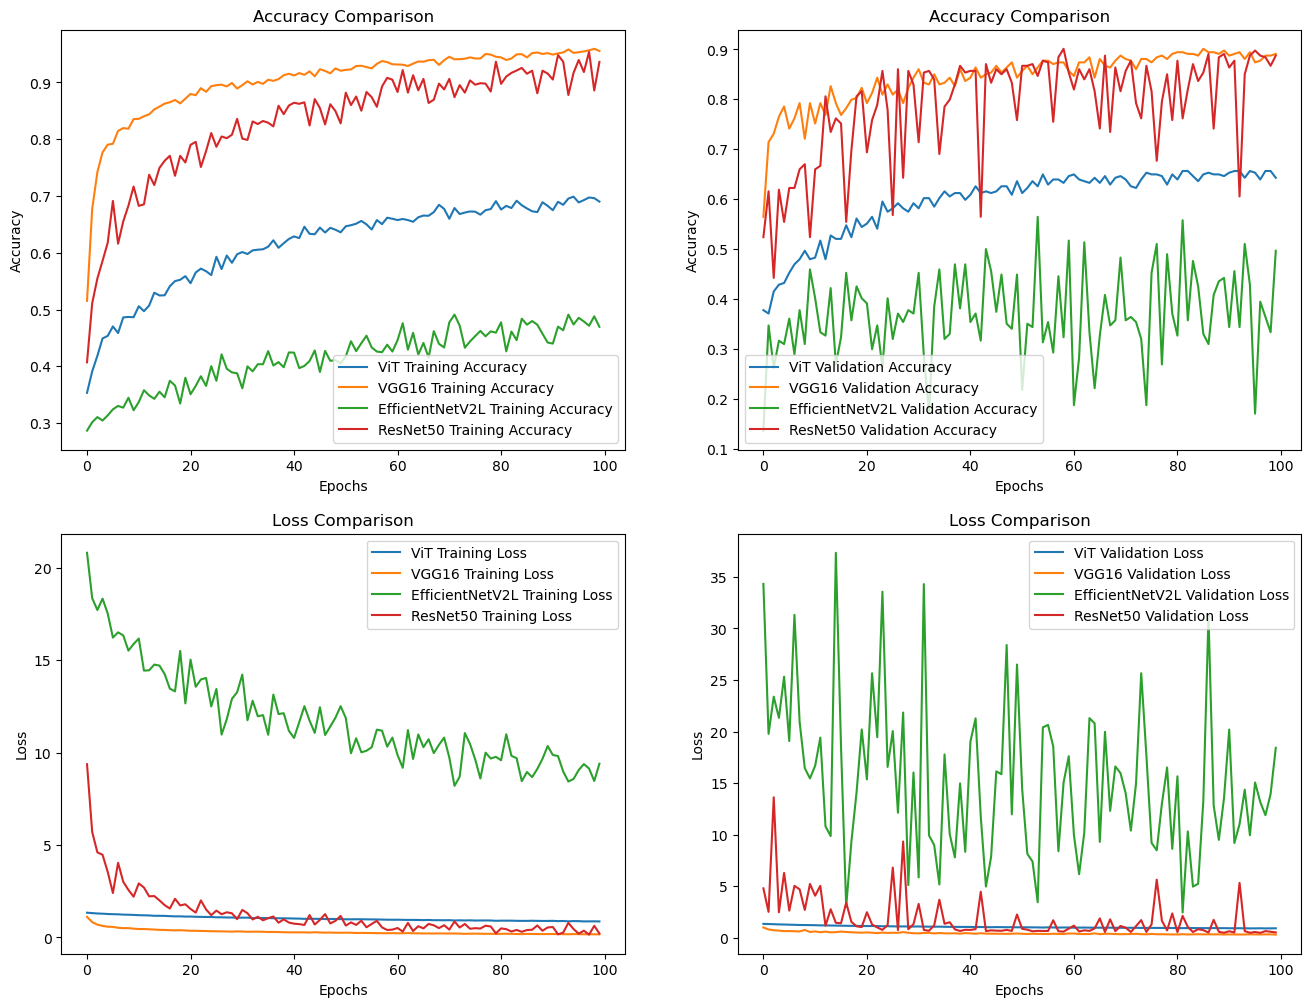

In [24]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics for each model
def plot_metrics(ax, histories, model_names, metric_name, train=True, val=True):
    for history, model_name in zip(histories, model_names):
        if train:
            ax.plot(history.history[metric_name], label=f'{model_name} Training {metric_name.capitalize()}')
        if val:
            ax.plot(history.history[f'val_{metric_name}'], label=f'{model_name} Validation {metric_name.capitalize()}')

    ax.set_title(f'{metric_name.capitalize()} Comparison')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name.capitalize())
    ax.legend()

model_histories = [history_vit, history_vgg, history_efficientnet, history_resnet]
model_names = ['ViT', 'VGG16', 'EfficientNetV2L', 'ResNet50']
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plot_metrics(axs[0, 0], model_histories, model_names, 'accuracy', train=True, val=False)
plot_metrics(axs[0, 1], model_histories, model_names, 'accuracy', train=False, val=True)
plot_metrics(axs[1, 0], model_histories, model_names, 'loss', train=True, val=False)
plot_metrics(axs[1, 1], model_histories, model_names, 'loss', train=False, val=True)

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 389ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████▎                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████▊    | 3/4 [00:40<00:09,  9.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████████████| 4/4 [00:59<00:00, 13.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [01:19, 19.76s/it]                              


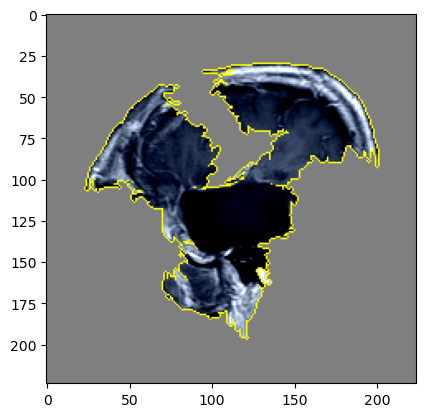

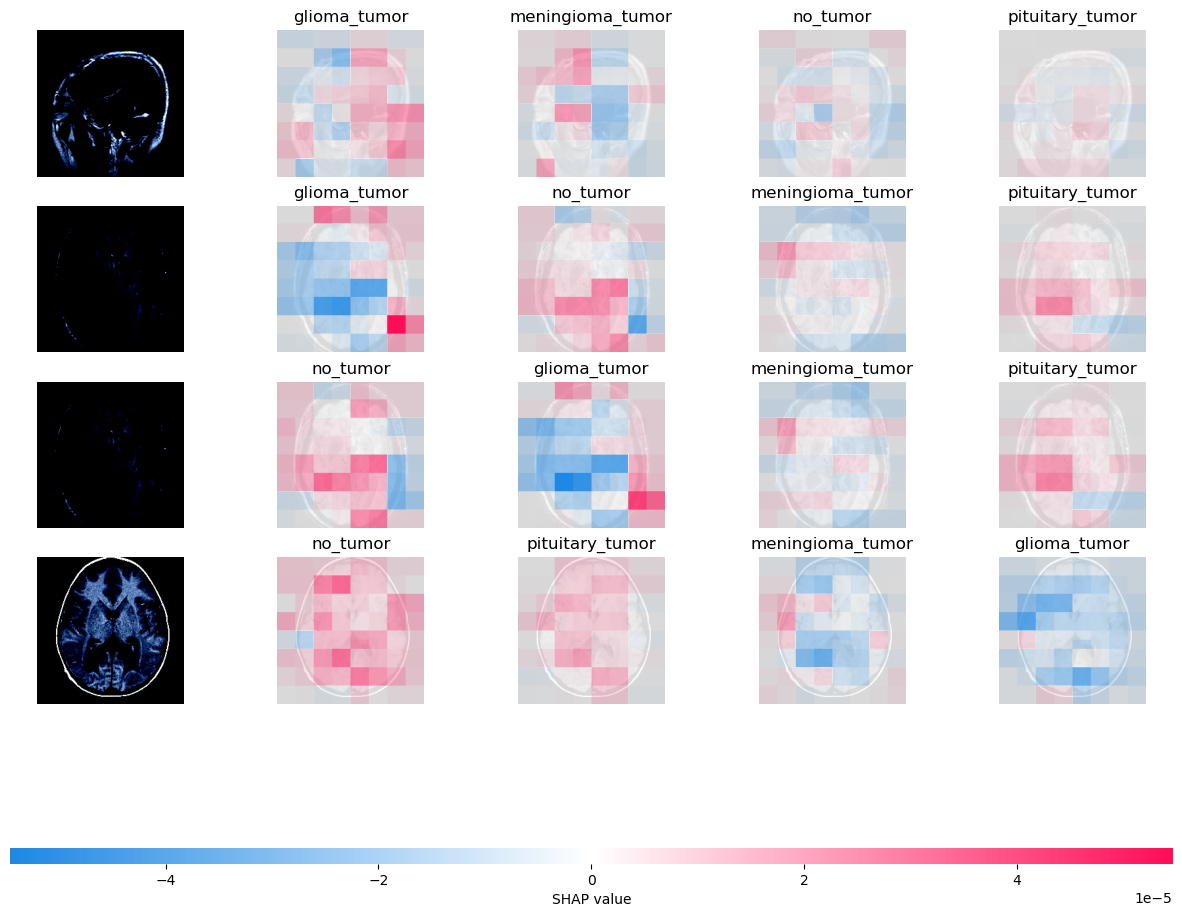

In [25]:
from lime.lime_image import LimeImageExplainer
import matplotlib.pyplot as plt
import shap
from skimage.segmentation import mark_boundaries

best_model = keras.models.load_model("aug01_model/"+model_name+"/best_model.h5")
explainer = LimeImageExplainer()
image_to_explain = X_test[0]
explanation = explainer.explain_instance(X_test[0].astype('double'), best_model.predict, top_labels=1, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
shap.initjs()
masker = shap.maskers.Image(explanation.top_labels[0], X_test[0].shape)
explainer = shap.Explainer(best_model, masker, output_names=classes)
explainer
shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])
shap_values.shape
shap.image_plot(shap_values)